In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('atlantic.csv')

###cleaning data###
df = df[df.iloc[:,10]!=-999]
df['Latitude'] = df['Latitude'].str.replace('[a-zA-Z]','')
df['Longitude'] = df['Longitude'].str.replace('[a-zA-Z]','')
df['Longitude'] = df['Longitude'].astype(float)
df['Longitude'] = -1*df['Longitude'] #since the longtitude is in the west

status = pd.unique(df['Status'])
print(status)

for i in range(len(status)):
    df['Status'].replace(status[i], i, inplace=True)
    
df.head()

[' TD' ' TS' ' HU' ' EX' ' WV' ' LO' ' SS' ' SD' ' DB']


,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
43104,AL012004,ALEX,20040731,1800,,0,30.3,-78.3,25,1010,...,0,0,0,0,0,0,0,0,0,0
43105,AL012004,ALEX,20040801,0,,0,31.0,-78.8,25,1009,...,0,0,0,0,0,0,0,0,0,0
43106,AL012004,ALEX,20040801,600,,0,31.5,-79.0,25,1009,...,0,0,0,0,0,0,0,0,0,0
43107,AL012004,ALEX,20040801,1200,,0,31.6,-79.1,30,1009,...,0,0,0,0,0,0,0,0,0,0
43108,AL012004,ALEX,20040801,1800,,1,31.6,-79.2,35,1009,...,50,0,0,0,0,0,0,0,0,0


In [3]:
### Helper variables to visualize hurricane trajectory###
ID = pd.unique(df['ID'])
print(min(df['Latitude']), max(df['Latitude']), min(df['Longitude']), max(df['Longitude']))

10.0 9.9 -106.7 -0.0


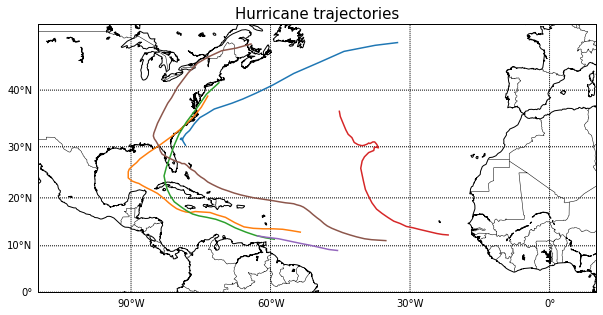

In [4]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=0.,urcrnrlon=10.,urcrnrlat=50.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.drawparallels(np.arange(-90,90,10),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180,180,30),labels=[0,0,0,1])

#drawing first 5 hurricanes in the dataset
for i in range(len(ID)):
    if i <= 5:
        lat, long = df[df['ID']==ID[i]]['Latitude'], df[df['ID']==ID[i]]['Longitude']
        xpt, ypt = m(np.array(long), np.array(lat))
        m.plot(xpt, ypt)
    else:
        break

plt.title('Hurricane trajectories', fontsize=15)
plt.show()

In [5]:
def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True

#chekcing if values are finite
all_data = df.drop(['ID','Name','Date','Time','Event'], axis=1).values 
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
X = np.array(df.drop(['Name','Date','Time','Event','Latitude','Longitude'], axis=1).values)
y = df[df.columns[6:8]] #outputs (hurricane location, latitude and longitude)
print(X.shape, y.shape)

(5921, 16) (5921, 2)


In [6]:
x_columns = df.drop(['Name','Date','Time','Event','Latitude','Longitude'], axis=1)
x_string = [str(name) for name in x_columns.columns[1:]]
print(x_string)

['Status', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE', 'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE', 'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW', 'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW']


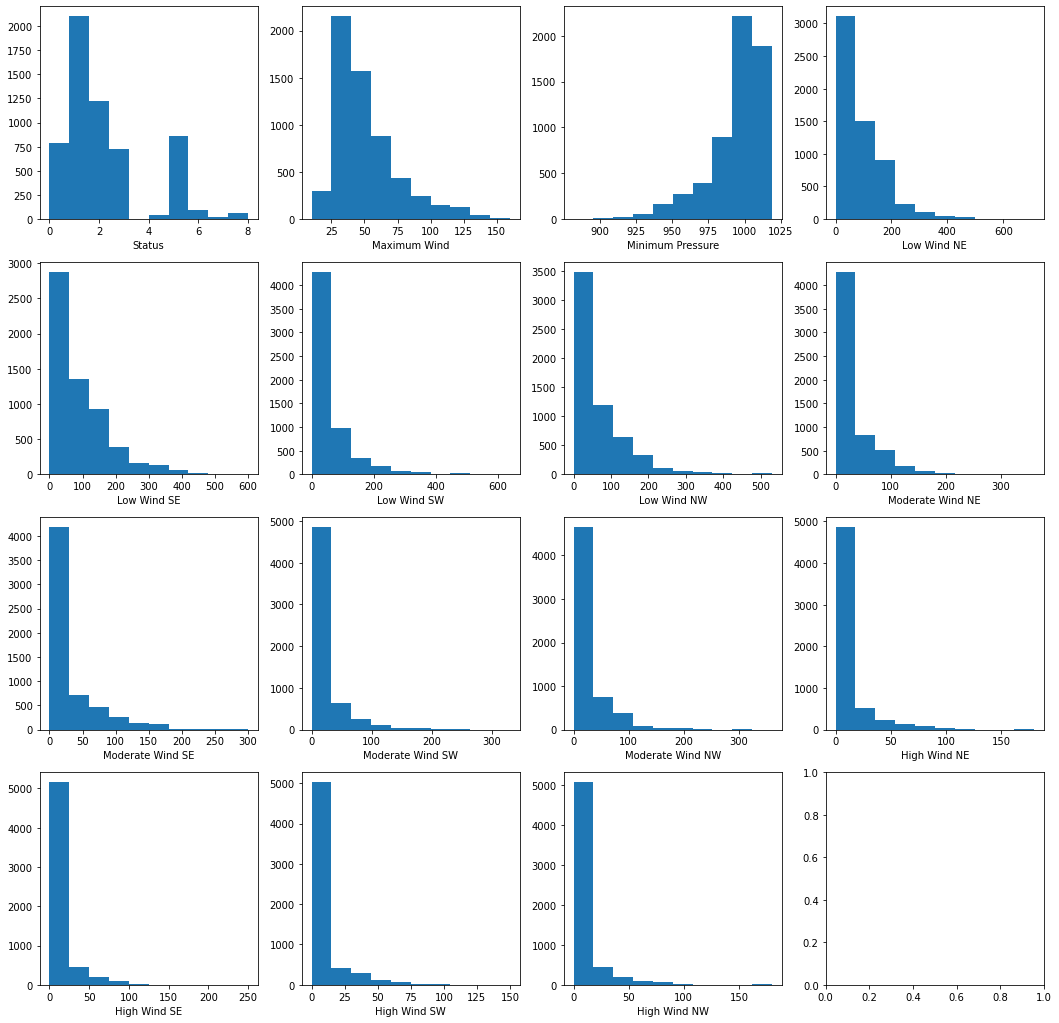

In [7]:
#visualizing the features
N = len(x_string)
n = int(np.sqrt(N))
fig, axes = plt.subplots(n+1, n+1, figsize=(6*n, 6*n))
ax = axes.ravel()
for i in range(N):
    ax[i].hist(X[:,i+1])
    ax[i].set_xlabel(x_string[i])

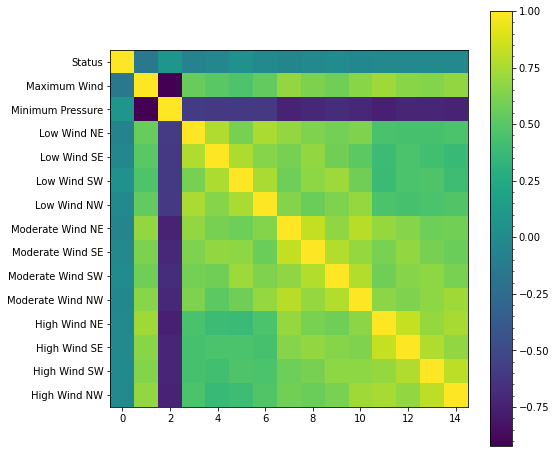

In [8]:
#check correlation numerical features

Xs = X[:,1:].astype(np.float) #ID might be useful later when training the model. But here ID will not be considered
X_scaled = (Xs-Xs.mean(axis=0))/Xs.std(axis=0)
co_var = np.cov(X_scaled.T)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_yticks(np.arange(len(x_string)))
ax.set_yticklabels(x_string)
c = ax.imshow(co_var)
cbar = fig.colorbar(c)
cbar.minorticks_on();

The covariance matrix shows that status is not correlated to any feature.

[0.61138338 0.10248746 0.07033118 0.03797264 0.03610686 0.03302828
 0.02579875 0.02215423 0.01458289 0.01270594]


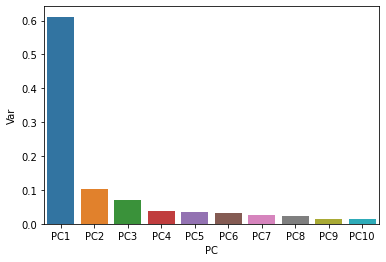

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

Xs = StandardScaler().fit_transform(Xs)
pca = PCA(n_components=10)
pc = pca.fit_transform(Xs)

pc_df = pd.DataFrame(data = pc)
print(pca.explained_variance_ratio_)
pca_df = pd.DataFrame({'Var':pca.explained_variance_ratio_, 'PC':['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']})

sns.barplot(x='PC', y='Var', data=pca_df)

- PC1 explains more than 60% of the variance in the data

In [10]:
#number of components to capture 0.9 variance

pca = PCA(0.9)
pca.fit(Xs)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

print('number of PCs to keep:',pca.n_components_)

number of PCs to keep: 7


## If you guys are trying to use the data set, use X as the input and y as output.

In [11]:
X

array([['AL012004', 0, 25, ..., 0, 0, 0],
       ['AL012004', 0, 25, ..., 0, 0, 0],
       ['AL012004', 0, 25, ..., 0, 0, 0],
       ...,
       ['AL122015', 3, 50, ..., 0, 0, 0],
       ['AL122015', 3, 45, ..., 0, 0, 0],
       ['AL122015', 3, 45, ..., 0, 0, 0]], dtype=object)

In [12]:
np.array(y)

array([['30.3', -78.3],
       ['31.0', -78.8],
       ['31.5', -79.0],
       ...,
       ['41.5', -49.2],
       ['40.8', -47.5],
       ['40.7', -45.4]], dtype=object)